# Cell calling
<b> Mai-Linh Ton </b>
April 04, 2020

In [2]:
library(DropletUtils)
library(ggplot2)
library(Matrix)
library(BiocParallel)
ncores = 3
mcparam = MulticoreParam(workers = ncores)
register(mcparam)

library(knitr)
library(reshape2)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

In [4]:
##===Read in files from 01 swappedDrops output===##
dirout = ("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/")
mtx_loc=paste0(dirout, "swapped/sample", 1:26, "/matrix.mtx")
bc_loc=paste0(dirout, "swapped/sample", 1:26, "/barcodes.tsv")

# read matrices and tables into a single variable
matrices = bplapply(mtx_loc, readMM)
bcs = bplapply(bc_loc, function(x) read.table(x, header = FALSE, stringsAsFactors = FALSE)[,1])
               
#correct barcode sample number
for(i in 1:length(bcs)){
  bcs[[i]] = paste0(bcs[[i]], "-", i)
}               

In [5]:
#csv containing cell sample number and theiler stage
exp_design = read.table("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/sample_stage_map_rabbit.csv", sep = ",", header = TRUE)
exp_design

sample,stage,barcodes,batch,embryo_pool,ID
<int>,<fct>,<fct>,<int>,<int>,<fct>
1,GD7,TCTTAAAG-CGAGGCTC-GTCCTTCT-AAGACGGA,1,1,SIGAA9
2,GD7,CTGTAACT-TCTAGCGA-AGAGTGTG-GACCCTAC,1,2,SIGAB9
3,GD7,GCGCAGAA-ATCTTACC-TATGGTGT-CGAACCTG,1,3,SIGAC9
4,GD7,AGGAGATG-GATGTGGT-CTACATCC-TCCTCCAA,1,4,SIGAD9
5,GD7,TTGTTTCC-GGAGGAGG-CCTAACAA-AACCCGTT,1,5,SIGAE9
6,GD7,CAAGCTCC-GTTCACTG-TCGTGAAA-AGCATGGT,1,6,SIGAF9
7,GD8,GTCCGGTC-AAGATCAT-CCTGAAGG-TGATCTCA,1,7,SIGAA11
8,GD8,GTTCCTCA-AGGTACGC-TAAGTATG-CCCAGGAT,1,8,SIGAB11
9,GD8,GAGGATCT-AGACCATA-TCCTGCGC-CTTATGAG,1,9,SIGAC11


In [13]:
set.seed(42)
#do call
outs = lapply(matrices, emptyDrops, niters = 20000, BPPARAM = mcparam, lower = 100, retain = Inf)


#identify cells
sigs = lapply(outs, function(x) x$FDR <= 0.01 & !is.na(x$FDR))

#subset the cells
cells = lapply(1:length(matrices), function(i) matrices[[i]][, sigs[[i]]])
barcodes = lapply(1:length(bcs), function(i) bcs[[i]][sigs[[i]]])

#append
counts = do.call(cbind, cells)
barcodes = do.call(c, barcodes)


In [14]:
#save
writeMM(counts, file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/raw_counts.mtx")
write.table(barcodes, file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/barcodes.tsv", col.names = FALSE, row.names = FALSE, quote = FALSE)
file.copy(from = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/swapped/sample1/genes.tsv",
          to = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/genes.tsv",
          overwrite = TRUE)

NULL

[1] TRUE

In [1]:
# load('/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/workspace.RData')

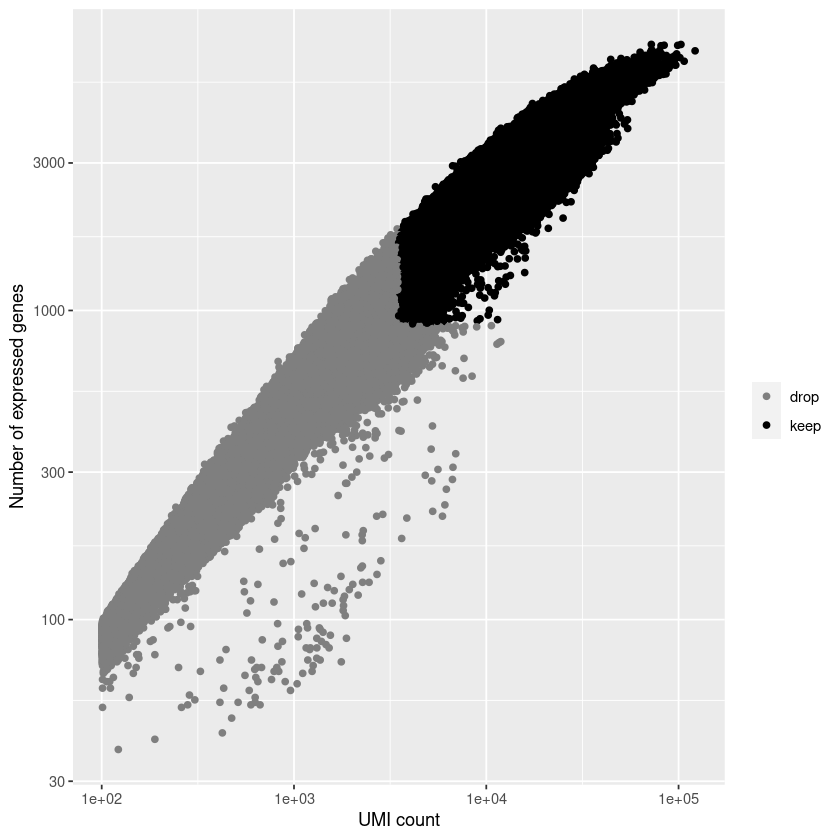

In [3]:
qplot(lib.sizes, ngenes, col = ifelse(lib.sizes > 3500 & ngenes > 900, "keep", "drop")) +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "UMI count", y = "Number of expressed genes") +
  scale_color_manual(values = c("drop" = "grey50", "keep" = "black"), name = "")

In [4]:
summary(lib.sizes)
barcodes_trim = barcodes[lib.sizes > 3500 & ngenes > 900]
length(barcodes_trim)
counts_trim = counts[,lib.sizes > 3500 & ngenes > 900]
ncol(counts_trim)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    101     602    1280    4486    6090  121907 

[1] 180790

[1] 180790

The estimated capture is 180,883 cells according to the calculations made during sample prep.

In [5]:
#save matrix and barcodes of cells that were filtered for minimum reads & genes
write.table(barcodes_trim, file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/barcodes_trimmed.tsv", col.names = FALSE, row.names = FALSE, quote = FALSE)
writeMM(counts_trim, file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/raw_counts_trimmed.mtx")

NULL

In [ ]:
save.image('/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/workspace.RData')